In [1]:
import numpy as np
import math
import time
import cv2
from matplotlib import pyplot as plt

In [2]:
# Image shape: 700 x 474
img = cv2.imread('../../data/sample_data/livingroom.jpg',0)

In [3]:
# Check consecutivity Algorithm
def check_consec(predicate_list, consec_n, row, col, kpx, kpy):
    for i in range(16):
        count = 0
        for j in range(consec_n):
            if (predicate_list[i + j] is True):
                count += 1
            if (count == consec_n):
                kpx.append(row)
                kpy.append(col)
                break
        if (count == consec_n):
            break
    return kpx, kpy

# Fast Algorithm, radius is hard-coded to 3
def FAST(image, threshold=10, consec_n=12):
    
    # Initialize keypoint list to return
    kpx = []
    kpy = []
    
    # Perform algorithm on all pixels of the image
    for col in range(3,image.shape[1] - 3):
        for row in range(3, image.shape[0] - 3):
            Ip = image[row][col]
            count_bright = 0
            count_dark   = 0
            # Check north
            if (image[row - 3][col] > Ip + threshold):
                count_bright += 1
            elif (image[row - 3][col] < Ip - threshold):
                count_dark   += 1
            # Check east
            if (image[row][col + 3] > Ip + threshold):
                count_bright += 1
            elif (image[row][col + 3] < Ip - threshold):
                count_dark   += 1
            # Check south
            if (image[row + 3][col] > Ip + threshold):
                count_bright += 1
            elif (image[row + 3][col] < Ip - threshold):
                count_dark   += 1
            # Check west
            if (image[row][col - 3] > Ip + threshold):
                count_bright += 1
            elif (image[row][col - 3] < Ip - threshold):
                count_dark   += 1
                
            # Check fast condition
            if (count_dark > 3 or count_bright > 3):
                bright_predicate = []
                dark_predicate = []
                row_increment  = [-3,-3,-2,-1,0,1,2,3,3,3,2,1,0,-1,-2,-3]
                col_increment  = [0,1,2,3,3,3,2,1,0,-1,-2,-3,-3,-3,-2,-1]
                
                # Start checking all 16 neighbor pixels
                for i in range(16):
                    pix_intensity = image[row + row_increment[i]][col + col_increment[i]]
                    bright_predicate.append(bool(pix_intensity > (Ip + threshold)))
                    dark_predicate  .append(bool(pix_intensity < (Ip - threshold)))
                
                #Perform wrap around
                bright_predicate.extend(bright_predicate[0:consec_n])
                dark_predicate  .extend(dark_predicate  [0:consec_n])
                
                # Check consecutive bright
                keypoint = check_consec(bright_predicate, consec_n, row, col, kpx, kpy)
                # Check consecutive dark
                keypoint = check_consec(dark_predicate, consec_n, row, col, kpx, kpy)
                
            else:
                continue
                
    return kpx, kpy

Naive FAST on python takes: 8.185133457183838seconds
There are a lot of keypoints detected along edges (unwanted)


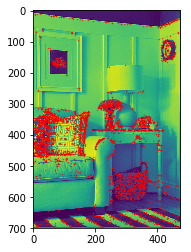

In [4]:
# Benchmark naive FAST
start = time.time()
kpx, kpy = FAST(img)
end = time.time()
print("Naive FAST on python takes: " + str(end-start) + "seconds")
print("There are a lot of keypoints detected along edges (unwanted)")

# Example FAST without any filter
plt.imshow(img)
plt.scatter(kpy, kpx,s=0.1,c='red')
plt.show()

In [5]:
# Harris Corner Measure
# (needed Sobel, did it in CUDA already for EEC171...will be skipped here)
def harris(image, kpx, kpy, kappa=0.04, display=False,size=5):
    
    # Compute the Gradients using Sobel
    Ix = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    Iy = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    
    # Compute element-wise products
    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy
    
    # Compute the sum of product of derivative with Fast Gaussian Blur
    kernel = np.ones((size,size),np.float32)/(size*size)
    Sx2 = cv2.filter2D(Ix2,-1,kernel) #convolution
    Sy2 = cv2.filter2D(Iy2,-1,kernel) #convolution
    Sxy = cv2.filter2D(Ixy,-1,kernel) #convolution
    
    # Displaying purposes
    if (display is True):
        plt.subplot(1,2,1),plt.imshow(Ix,cmap = 'gray')
        plt.subplot(1,2,2),plt.imshow(Iy,cmap = 'gray')
        plt.show()
    
    # Calculating corner strength for all keypoints
    R = []
    if (kpx == [] and kpy == []):
        R = np.empty([image.shape[0], image.shape[1]])
        for col in range(image.shape[1]):
            for row in range(image.shape[0]):
                H = np.array([[Sx2[row][col],Sxy[row][col]],
                              [Sxy[row][col],Sy2[row][col]]])
                R[row][col] = np.linalg.det(H) - kappa*(np.trace(H))**2
    else:
        if (len(kpx) != len(kpy)):
            print("Error: keypoints kpx, kpy have different lengths")
        else:
            for row, col in zip(kpx,kpy):
                H = np.array([[Sx2[row][col],Sxy[row][col]],
                              [Sxy[row][col],Sy2[row][col]]])
                R.append(np.linalg.det(H) - kappa*(np.trace(H))**2)
    
    return R

Naive Harris on python takes: 0.07180666923522949seconds
With Harris filter, the edge keypoints are gone


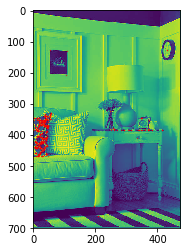

In [6]:
# Benchmark naive Harris
start = time.time()
R = harris(img,kpx,kpy,display=False)
end = time.time()
print("Naive Harris on python takes: " + str(end-start) + "seconds")

# Sort the keypoint by corner strength, take N = 100
coord = tuple(zip(kpx,kpy))
R_dict= dict(zip(coord,R))

sorted_coord = sorted(R_dict, key=lambda key: R_dict[key], reverse=True)[0:500]
sorted_kpx, sorted_kpy = zip(*sorted_coord)

# Example FAST with Harris filter
print ("With Harris filter, the edge keypoints are gone")
plt.imshow(img)
plt.scatter(sorted_kpy, sorted_kpx,s=0.1,c='red')
plt.show()

In [7]:
def non_max_supression(corner_strength, kpx, kpy, max_distance=5, N=100):
    
    # Sort by  corner strength
    coord = tuple(zip(kpx,kpy))
    R_dict= dict(zip(coord,R))
    sorted_coord = sorted(R_dict, key=lambda key: R_dict[key], reverse=True)
    
    non_max_sorted_coord = [sorted_coord[0]]
    sorted_coord.pop(0)
    for i in range(N):
        if (len(sorted_coord) == 0):
            break
        selector = non_max_sorted_coord[-1]
        sorted_coord = [x for x in sorted_coord if (np.linalg.norm(np.asarray(x) - np.asarray(selector)) > max_distance)]
        non_max_sorted_coord.append(sorted_coord[0])
        sorted_coord.pop(0)
    return non_max_sorted_coord

Naive non-maximal supression on python takes: 8.902218341827393seconds
With Harris filter + non maximal supression


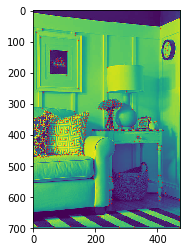

In [8]:
# Benchmark naive non-maximal supression
start = time.time()
non_max_sorted_coord = non_max_supression(R, kpx, kpy, N=500)
end = time.time()
print("Naive non-maximal supression on python takes: " + str(end-start) + "seconds")

nonmax_sorted_kpx, nonmax_sorted_kpy = zip(*non_max_sorted_coord)

# Example FAST with Harris filter
print ("With Harris filter + non maximal supression")
plt.imshow(img)
plt.scatter(nonmax_sorted_kpy, nonmax_sorted_kpx,s=0.1,c='red')
plt.show()

In [9]:
def moment(i,j,patch):
    M = 0
    for x in range(patch.shape[0]):
        for y in range(patch.shape[1]):
            Ixy = patch[x][y]
            M += x^i*y^j*Ixy
    return M

# Discretize lookup angle 
def lookup_theta(raw_radian):
    raw_degree = raw_radian * 180 / math.pi
    if (0 <= raw_degree and raw_degree > 12):
        return 0
    elif (12 <= raw_degree and raw_degree > 24):
        return 12
    elif (24 <= raw_degree and raw_degree > 36):
        return 24
    elif (36 <= raw_degree and raw_degree > 48):
        return 36
    elif (48 <= raw_degree and raw_degree > 60):
        return 48
    elif (60 <= raw_degree and raw_degree > 72):
        return 60
    elif (72 <= raw_degree and raw_degree > 84):
        return 72
    elif (84 <= raw_degree and raw_degree > 96):
        return 84
    elif (96 <= raw_degree and raw_degree > 108):
        return 96
    elif (108 <= raw_degree and raw_degree > 120):
        return 108
    elif (120 <= raw_degree and raw_degree > 132):
        return 120
    elif (132 <= raw_degree and raw_degree > 144):
        return 132
    elif (144 <= raw_degree and raw_degree > 156):
        return 144
    elif (156 <= raw_degree and raw_degree > 168):
        return 156
    elif (168 <= raw_degree and raw_degree > 180):
        return 168
    else:
        return 180

In [10]:
# oriented fast given the keypoints are already Harris-filtered and non-max supressed
def oFAST(image, patch_radius = 3):
    kpx, kpy = FAST(image)
    R = harris(img,kpx,kpy,display=False)
    non_max_sorted_coord = non_max_supression(R, kpx, kpy, N=500)
    oriented_kp = []
    for coord in non_max_sorted_coord:
        x = coord[0]
        y = coord[1]
        # Calculate Centroid
        patch = image[x-patch_radius:x+patch_radius,y-patch_radius:y+patch_radius]
        #M00 = moment(0,0,patch)
        M01 = moment(0,1,patch)
        M10 = moment(1,0,patch)
        #centroid = tuple(M10/M00, M01/M00) #Dont think this is needed
        theta = np.radians(lookup_theta(math.atan2(M01,M10)))
        oriented_kp.append(tuple([x,y,theta]))
    return oriented_kp

In [11]:
# Benchmark oFAST (this function combines several of the previous functions)
start = time.time()
oriented_kp = oFAST(img)
end = time.time()
print("oFAST on python takes: " + str(end-start) + "seconds")

oFAST on python takes: 17.16010808944702seconds


In [19]:
def gaussian_pick(center, patch, coord='x', sigma=2):
    sample = 0
    valid  = False
    while (not valid):
        sample = int(np.random.normal(center,sigma))
        try:
            if coord == 'x':
                intensity = patch[sample]
            else:
                intensity = patch[0][sample]
            valid = True
        except IndexError:
            valid = False
    return sample

def generate_test_matrix(x,y,patch, size = 128):
    
    valid = False
    S1 = []
    S2 = []
    for i in range(size*2):

        x1 = gaussian_pick(x, patch, 'x')
        S1.append(x1)
        y1 = gaussian_pick(y, patch, 'y')
        S2.append(y1)
        
    return np.asarray([S1,S2])

def generate_descriptor(patch,S,size = 128):
    descriptor = 0

    for i in range(size):
        p1 = patch[S[0][i*2]][S[1][i*2]]
        p2 = patch[S[0][i*2+1]][S[1][i*2+1]]
        
        if p1 > p2:
            descriptor += 2**(i)
                 
    return descriptor

In [20]:
def steerBRIEF(oriented_kp, image, patch_radius = 3):
    
    descriptors = []
    binary_size = 128
    
    # Smooth out the image
    kernel = np.ones((5,5),np.float32)/25
    smoothed_image = cv2.filter2D(image,-1,kernel) #Gaussian blur

    for coord in oriented_kp:
        x = coord[0]
        y = coord[1]
        theta = coord[2]

        # Patch with Rotational padding
        patch = smoothed_image[x-patch_radius:x+patch_radius,y-patch_radius:y+patch_radius]
        patch_size = patch.shape[0]
                        
        # Generate test matrix
        # This can be replace with a more intellegent pick
        S = generate_test_matrix(int(patch_size/2), int(patch_size/2), patch, size=binary_size)
        
        # Get Rotation Matrix
        R = np.asarray([[np.cos(theta), -1 * np.sin(theta)],[np.sin(theta), np.cos(theta)]])
        
        # Rotate the test matrix
        Stheta = R.dot(S)
        
        # Generate descriptor from test matrix
        descriptors.append(generate_descriptor(patch,S))
        
    return descriptors

In [21]:
# Benchmark steerBRIEF (taking keypoints from oFAST)
start = time.time()
des = steerBRIEF(oriented_kp, img)
end = time.time()
print("steerBRIEF on python takes: " + str(end-start) + "seconds")

steerBRIEF on python takes: 0.6193630695343018seconds


In [15]:
def pyramid(image,num_layers=4):
    layers = [image]
    width = image.shape[1]
    height = image.shape[0]
    for i in range(num_layers):
        width /= 2
        height /= 2
        layers.append(cv2.resize(image,(int(width),int(height))))
    return layers

CV2 pyramid takes: 0.0009989738464355469seconds


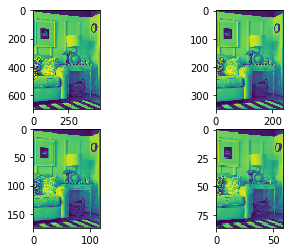

In [16]:
# Benchmark CV2 pyramid
start = time.time()
layers = pyramid(img)
end = time.time()
print("CV2 pyramid takes: " + str(end-start) + "seconds")

# Example pyramid layers
plt.subplot(2,2,1),plt.imshow(layers[0])
plt.subplot(2,2,2),plt.imshow(layers[1])
plt.subplot(2,2,3),plt.imshow(layers[2])
plt.subplot(2,2,4),plt.imshow(layers[3])
plt.show()

In [37]:
def ORB(image):
    layers = pyramid(image, num_layers=1)
    kp = []
    des = []
    for layer in layers:
        this_kp = oFAST(layer)
        kp.append(this_kp)
        des.append(steerBRIEF(this_kp, layer))
    return (kp, des)

In [38]:
# Benchmark ORB 
start = time.time()
kp, des = ORB(img)
end = time.time()
print("steerBRIEF on python takes: " + str(end-start) + "seconds")

steerBRIEF on python takes: 20.116202116012573seconds
